In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

import pymongo

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

from nltk.tokenize import sent_tokenize, word_tokenize
import re
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

In [6]:
try:
    conn=pymongo.MongoClient()
    print ("Connected successfully!!!")
except pymongo.errors.ConnectionFailure as e:
    print ("Could not connect to MongoDB: {}s".format(e)) 
conn

Connected successfully!!!


MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [7]:
vscode = conn.vscode
vs = vscode.Issues

In [8]:
number = []
url = []
title = []
body = []
state = []
creator = []
created_at = []
comments = []
mentioned = []
subscribed = []
labeled = []
unlabeled = []
status = []
assigned = []
unassigned = []
crossreference = []

for cursor in vs.find():
    number.append(cursor["number"])
    url.append(cursor["url"])
    title.append(cursor["title"])
    state.append(cursor["state"])
    creator.append(cursor["creator"])
    created_at.append(cursor["created_at"])
    comments.append(cursor["comments"])
    subscribed.append(cursor["subscribed"])
    mentioned.append(cursor["mentioned"])
    if "body" in cursor:
        body.append(cursor["body"])
    else:
        body.append("") 
    if "labeled" in cursor:
        labeled.append(cursor["labeled"])
    else:
        labeled.append([])
    if "status" in cursor:
        status.append(cursor["status"])
    else:
        status.append([])
    if "assigned" in cursor:
        assigned.append(cursor["assigned"])
    else:
        assigned.append([])    
    if "unassigned" in cursor:
        unassigned.append(cursor["unassigned"])
    else:
        unassigned.append([])
    if "crossReferences" in cursor:
        crossreference.append(cursor["crossReferences"])
    else:
        crossreference.append([])   
    if "unlabeled" in cursor:
        unlabeled.append(cursor["unlabeled"])
    else:
        unlabeled.append([])        

In [9]:
df = pd.DataFrame()
df["number"] = number
df['url'] = url
df['title'] = title
df["body"] = body
df["state"] = state
df['creator'] = creator
df["created_at"] = created_at
df["comments"] = comments
df["subscribed"] = subscribed
df["mentioned"] = mentioned
df["labeled"] = labeled
df["unlabeled"] = unlabeled
df["status"] = status
df["assigned"] = assigned
df["unassigned"] = unassigned
df["crossreference"] = crossreference

In [17]:
df.head()

number                                                url  \
0   52719  https://api.github.com/repos/Microsoft/vscode/...   
1   52718  https://api.github.com/repos/Microsoft/vscode/...   
2   52717  https://api.github.com/repos/Microsoft/vscode/...   
3   52716  https://api.github.com/repos/Microsoft/vscode/...   
4   52715  https://api.github.com/repos/Microsoft/vscode/...   

                                               title  \
0                       The extensions stops working   
1  Display function param type details instead of...   
2     Setting to change the image preview background   
3  When I use extension management, the applicati...   
4  Attach to process: cannot put process '18117' ...   

                                                body state   creator  \
0  <!-- Please search existing issues to avoid cr...  open  18577289   
1  <!-- Please search existing issues to avoid cr...  open    499364   
2  Hello,\r\n\r\nRight now whenever you open an i...  open   8916053   
3  Issue Type: <b>Bug</b>\r\nHi, vscode Team.\r\n...  open   5129173   
4  - VSCode Version: 1.24.1\r\n- OS Version: Mac ...  open   5215504   

             created_at  comments  subscribed  mentioned            labeled  \
0  2018-06-23T04:56:33Z         1           0          0       [extensions]   
1  2018-06-23T03:37:23Z         0           0          0       [javascript]   
2  2018-06-23T03:05:01Z         1           1          1                 []   
3  2018-06-23T02:08:53Z         0           0          0                 []   
4  2018-06-23T01:30:53Z         1           0          0  [debug, question]   

  unlabeled                                             status  \
0        []                                                 []   
1        []                                                 []   
2        []                                                 []   
3        []  [[closed, 2018-06-23T02:09:41Z], [reopened, 20...   
4        []                   [[closed, 2018-06-23T16:20:37Z]]   

                             assigned unassigned crossreference  duplicate  
0                                  []         []             []          0  
1  [[12821956, 2018-06-23T03:37:44Z]]         []             []          0  
2                                  []         []             []          0  
3                                  []         []             []          0  
4   [[1898161, 2018-06-23T01:31:12Z]]         []             []          0

In [18]:
df['duplicate'] = df["labeled"].apply(lambda x: 1 if "*duplicate" in x or "duplicate" in x else 0)
# drop the duplicate issues
df = df.loc[df["duplicate"] == 0]

In [19]:
unlabels = [label for sublist in df.unlabeled.values for label in sublist]

In [20]:
pd.Series(unlabels).value_counts()[:20]

needs more info        2653
bug                    1727
new release            1650
workbench              1472
editor                  929
feature-request         504
insiders                421
editor-core             399
extensions              309
help wanted             295
integrated-terminal     262
verified                244
debug                   228
verification-needed     220
cla-required            215
important               214
verification-found      208
git                     202
question                178
under-discussion        170
dtype: int64

In [21]:
labels = [label for sublist in df.labeled.values for label in sublist]
pd.Series(labels).value_counts()[:30]

bug                    10903
verified                9250
needs more info         8387
feature-request         7161
new release             3178
debug                   3152
workbench               2928
editor                  2547
upstream                2112
integrated-terminal     1884
question                1695
javascript              1636
extensions              1629
typescript              1486
cla-not-required        1302
git                     1292
verification-needed     1243
important               1142
as-designed             1089
insiders                1071
api                     1050
help wanted              979
search                   893
testplan-item            866
tasks                    865
editor-core              860
debt                     744
ux                       680
accessibility            615
caused-by-extension      586
dtype: int64

# Market Basket Analysis of Labels

In [22]:
df.head()

number                                                url  \
0   52719  https://api.github.com/repos/Microsoft/vscode/...   
1   52718  https://api.github.com/repos/Microsoft/vscode/...   
2   52717  https://api.github.com/repos/Microsoft/vscode/...   
3   52716  https://api.github.com/repos/Microsoft/vscode/...   
4   52715  https://api.github.com/repos/Microsoft/vscode/...   

                                               title  \
0                       The extensions stops working   
1  Display function param type details instead of...   
2     Setting to change the image preview background   
3  When I use extension management, the applicati...   
4  Attach to process: cannot put process '18117' ...   

                                                body state   creator  \
0  <!-- Please search existing issues to avoid cr...  open  18577289   
1  <!-- Please search existing issues to avoid cr...  open    499364   
2  Hello,\r\n\r\nRight now whenever you open an i...  open   8916053   
3  Issue Type: <b>Bug</b>\r\nHi, vscode Team.\r\n...  open   5129173   
4  - VSCode Version: 1.24.1\r\n- OS Version: Mac ...  open   5215504   

             created_at  comments  subscribed  mentioned            labeled  \
0  2018-06-23T04:56:33Z         1           0          0       [extensions]   
1  2018-06-23T03:37:23Z         0           0          0       [javascript]   
2  2018-06-23T03:05:01Z         1           1          1                 []   
3  2018-06-23T02:08:53Z         0           0          0                 []   
4  2018-06-23T01:30:53Z         1           0          0  [debug, question]   

  unlabeled                                             status  \
0        []                                                 []   
1        []                                                 []   
2        []                                                 []   
3        []  [[closed, 2018-06-23T02:09:41Z], [reopened, 20...   
4        []                   [[closed, 2018-06-23T16:20:37Z]]   

                             assigned unassigned crossreference  duplicate  
0                                  []         []             []          0  
1  [[12821956, 2018-06-23T03:37:44Z]]         []             []          0  
2                                  []         []             []          0  
3                                  []         []             []          0  
4   [[1898161, 2018-06-23T01:31:12Z]]         []             []          0

In [23]:
df["labels"] = df.labeled.apply(lambda x: ", ".join(x))
df_basket = df[["number", "labels"]]

In [24]:
df_basket.head()

number           labels
0   52719       extensions
1   52718       javascript
2   52717                 
3   52716                 
4   52715  debug, question

In [25]:
df_pivoted = pd.get_dummies(df_basket.set_index("number")["labels"].str.split(', ', expand=True).stack())\
                                                                    .groupby("number").sum()

In [26]:
df_pivoted.head()

*caused-by-extension  *dev-question  *extension-candidate  \
number                                                                 
52719   0                     0              0                     0   
52718   0                     0              0                     0   
52717   1                     0              0                     0   
52716   1                     0              0                     0   
52715   0                     0              0                     0   

        *not-reproducible  *out-of-scope  *question  API  Accepting PRs  \
number                                                                    
52719                   0              0          0    0              0   
52718                   0              0          0    0              0   
52717                   0              0          0    0              0   
52716                   0              0          0    0              0   
52715                   0              0          0    0              0   

        Blocker  ...   workbench-status  workbench-tabs  workbench-title  \
number           ...                                                       
52719         0  ...                  0               0                0   
52718         0  ...                  0               0                0   
52717         0  ...                  0               0                0   
52716         0  ...                  0               0                0   
52715         0  ...                  0               0                0   

        workbench-touchbar  workbench-untitled  workbench-views  \
number                                                            
52719                    0                   0                0   
52718                    0                   0                0   
52717                    0                   0                0   
52716                    0                   0                0   
52715                    0                   0                0   

        workbench-welcome  workspace-edit  workspace-symbols  zoom  
number                                                              
52719                   0               0                  0     0  
52718                   0               0                  0     0  
52717                   0               0                  0     0  
52716                   0               0                  0     0  
52715                   0               0                  0     0  

[5 rows x 285 columns]

In [27]:
df_pivoted = df_pivoted.iloc[:, 1:]

In [28]:
frequent_itemsets = apriori(df_pivoted, min_support=0.01, use_colnames=True)

In [29]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)\
                                                        .sort_values(by="confidence", ascending=False)

antecedants                  consequents  \
9                    (verified, important)                        (bug)   
15  (feature-request, verification-needed)                   (verified)   
6                    (verification-needed)                   (verified)   
12             (needs more info, verified)                        (bug)   
10                        (important, bug)                   (verified)   
3                            (editor-core)                     (editor)   
0                              (important)                        (bug)   
8                        (debug, verified)                        (bug)   
1                               (verified)                        (bug)   
5                              (important)                   (verified)   
13             (verified, feature-request)        (verification-needed)   
14         (verified, verification-needed)            (feature-request)   
4                    (verification-needed)            (feature-request)   
7                             (debug, bug)                   (verified)   
11                             (important)              (verified, bug)   
2                                    (bug)                   (verified)   
16                   (verification-needed)  (verified, feature-request)   

    antecedent support  consequent support   support  confidence       lift  \
9             0.018498            0.240387  0.017197    0.929678   3.867420   
15            0.019534            0.203942  0.017616    0.901806   4.421871   
6             0.027405            0.203942  0.024539    0.895414   4.390531   
12            0.017330            0.240387  0.014816    0.854962   3.556604   
10            0.020394            0.203942  0.017197    0.843243   4.134718   
3             0.018961            0.056156  0.015764    0.831395  14.805170   
0             0.025179            0.240387  0.020394    0.809982   3.369491   
8             0.023282            0.240387  0.018366    0.788826   3.281480   
1             0.203942            0.240387  0.157223    0.770919   3.206989   
5             0.025179            0.203942  0.018498    0.734676   3.602375   
13            0.024032            0.027405  0.017616    0.733028  26.747543   
14            0.024539            0.157884  0.017616    0.717880   4.546872   
4             0.027405            0.157884  0.019534    0.712792   4.514646   
7             0.026546            0.203942  0.018366    0.691860   3.392435   
11            0.025179            0.157223  0.017197    0.683012   4.344230   
2             0.240387            0.203942  0.157223    0.654040   3.206989   
16            0.027405            0.024032  0.017616    0.642800  26.747543   

    leverage  conviction  
9   0.012751   10.801952  
15  0.013632    8.106980  
6   0.018950    7.611538  
12  0.010650    5.237331  
10  0.013038    5.078300  
3   0.014699    5.597973  
0   0.014342    3.997594  
8   0.012769    3.597090  
1   0.108198    3.315913  
5   0.013363    3.000324  
13  0.016958    3.643052  
14  0.013742    2.984952  
4   0.015207    2.932072  
7   0.012952    2.583433  
11  0.013239    2.658706  
2   0.108198    2.301012  
16  0.016958    2.732270

In [30]:
association_rules(frequent_itemsets, metric="lift", min_threshold=5)

antecedants                  consequents  \
0                (editor-core)                     (editor)   
1                     (editor)                (editor-core)   
2                 (javascript)                 (typescript)   
3                 (typescript)                 (javascript)   
4                 (javascript)                   (upstream)   
5                   (upstream)                 (javascript)   
6  (verified, feature-request)        (verification-needed)   
7        (verification-needed)  (verified, feature-request)   

   antecedent support  consequent support   support  confidence       lift  \
0            0.018961            0.056156  0.015764    0.831395  14.805170   
1            0.056156            0.018961  0.015764    0.280722  14.805170   
2            0.036070            0.032763  0.010010    0.277506   8.470099   
3            0.032763            0.036070  0.010010    0.305518   8.470099   
4            0.036070            0.046565  0.010583    0.293399   6.300845   
5            0.046565            0.036070  0.010583    0.227273   6.300845   
6            0.024032            0.027405  0.017616    0.733028  26.747543   
7            0.027405            0.024032  0.017616    0.642800  26.747543   

   leverage  conviction  
0  0.014699    5.597973  
1  0.014699    1.363923  
2  0.008828    1.338748  
3  0.008828    1.387984  
4  0.008903    1.349325  
5  0.008903    1.247439  
6  0.016958    3.643052  
7  0.016958    2.732270

## Conclusions:
* the labels Bug, Verified and Important appear together a lot, for example if an issue has the label Verified and Important it will also have the label Bug in 93% of the situations
* there are other different combinations of this 3 labels with high confidence, verified and bug, important and bug, bug important and verified. There seems to exist a tendency for the important issues being Bugs and are verified for a faster solution
* editor-core and editor have a confidence of 83%
* we see also several rules with strong confidence between the labels Feature-Request, verification-needed and verified
* verification needed and verified also appear almost always together but that probably won't help us   



* with high lift we have editor-core and editor once again, and rules involving typescript, javascript and upstream

## dropping labels Verified and Verification-needed, they don't seem to be important and using a lower support to find more interesting patterns

In [31]:
df_pivoted2 = df_pivoted.drop(["verified", "verification-needed"], axis=1)

In [32]:
frequent_itemsets2 = apriori(df_pivoted2, min_support=0.005, use_colnames=True)
association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.5)\
                                                        .sort_values(by="confidence", ascending=False)

antecedants        consequents  antecedent support  \
6             (electron)         (upstream)            0.007915   
5          (editor-core)           (editor)            0.018961   
1            (important)              (bug)            0.025179   
2   (verification-found)              (bug)            0.006570   
8          (on-testplan)  (feature-request)            0.010385   
0            (candidate)              (bug)            0.008753   
4       (editor-contrib)           (editor)            0.007232   
9    (freeze-slow-crash)  (needs more info)            0.010781   
7  (extension-candidate)  (feature-request)            0.008555   
3              (windows)              (bug)            0.009877   

   consequent support   support  confidence       lift  leverage  conviction  
6            0.046565  0.007320    0.924791  19.860239  0.006951   12.677155  
5            0.056156  0.015764    0.831395  14.805170  0.014699    5.597973  
1            0.240387  0.020394    0.809982   3.369491  0.014342    3.997594  
2            0.240387  0.005314    0.808725   3.364260  0.003734    3.971309  
8            0.157884  0.008069    0.777070   4.921769  0.006430    3.777490  
0            0.240387  0.006570    0.750630   3.122587  0.004466    3.046124  
4            0.056156  0.005314    0.734756  13.084255  0.004907    3.558401  
9            0.184915  0.007474    0.693252   3.749030  0.005481    2.657177  
7            0.157884  0.005247    0.613402   3.885137  0.003897    2.178273  
3            0.240387  0.005225    0.529018   2.200691  0.002851    1.612827

In [33]:
association_rules(frequent_itemsets2, metric="lift", min_threshold=5)

antecedants       consequents  antecedent support  \
0   (editor-contrib)          (editor)            0.007232   
1           (editor)  (editor-contrib)            0.056156   
2      (editor-core)          (editor)            0.018961   
3           (editor)     (editor-core)            0.056156   
4         (electron)        (upstream)            0.007915   
5         (upstream)        (electron)            0.046565   
6       (javascript)      (typescript)            0.036070   
7       (typescript)      (javascript)            0.032763   
8       (javascript)        (upstream)            0.036070   
9         (upstream)      (javascript)            0.046565   
10      (typescript)        (upstream)            0.032763   
11        (upstream)      (typescript)            0.046565   

    consequent support   support  confidence       lift  leverage  conviction  
0             0.056156  0.005314    0.734756  13.084255  0.004907    3.558401  
1             0.007232  0.005314    0.094621  13.084255  0.004907    1.096523  
2             0.056156  0.015764    0.831395  14.805170  0.014699    5.597973  
3             0.018961  0.015764    0.280722  14.805170  0.014699    1.363923  
4             0.046565  0.007320    0.924791  19.860239  0.006951   12.677155  
5             0.007915  0.007320    0.157197  19.860239  0.006951    1.177125  
6             0.032763  0.010010    0.277506   8.470099  0.008828    1.338748  
7             0.036070  0.010010    0.305518   8.470099  0.008828    1.387984  
8             0.046565  0.010583    0.293399   6.300845  0.008903    1.349325  
9             0.036070  0.010583    0.227273   6.300845  0.008903    1.247439  
10            0.046565  0.009635    0.294078   6.315438  0.008109    1.350624  
11            0.032763  0.009635    0.206913   6.315438  0.008109    1.219585

## Conclusions:
* Issues with the label Electron also have the label Upstream in 92% of the cases
* Issues with Editor-Core also have Editor with 83% confidence
* Important and Bug are together in 81% of the situations
* On-testplan label usually has the label Feature-Request and Extension-Candidate is also usually a feature-request
* Candidate and bug also appear together often


* with high lift we have again the different combinations of typescript, javascript and upstream and combinations of editor, editor-contrib and editor-core


# Some labels are attributed and later removed, create a list of only the labels remaining for each Issue

In [34]:
df_clean = df[["number", "labeled", "unlabeled"]]

In [35]:
clean_labels = []
for label_list, unlabel_list in df_clean[["labeled", "unlabeled"]].values:
    clean = []
    for label in label_list:
        if (label.lower() not in unlabel_list) & (label not in unlabel_list):
            clean.append(label)
    clean_labels.append(clean)          

In [36]:
df_clean["labels"] = clean_labels

/home/alberto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
df_clean["labels"] = df_clean["labels"].apply(lambda x: ", ".join(x))
df_basket3 = df_clean[["number", "labels"]]

/home/alberto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
df_pivoted3 = pd.get_dummies(df_basket3.set_index("number")["labels"].str.split(', ', expand=True).stack())\
                                                                    .groupby("number").sum()

In [39]:
df_pivoted3 = df_pivoted3.iloc[:, 1:]

In [40]:
df_pivoted3 = df_pivoted3.drop(["verified", "verification-needed"], axis=1)

In [41]:
frequent_itemsets3 = apriori(df_pivoted3, min_support=0.004, use_colnames=True)
association_rules(frequent_itemsets3, metric="confidence", min_threshold=0.4)\
                                                        .sort_values(by="confidence", ascending=False)

antecedants        consequents  antecedent support  \
6              (electron)         (upstream)            0.007474   
3             (important)              (bug)            0.020196   
9           (on-testplan)  (feature-request)            0.009855   
2             (candidate)              (bug)            0.005534   
5           (editor-core)           (editor)            0.010142   
0         (*out-of-scope)  (feature-request)            0.007232   
7   (extension-candidate)  (feature-request)            0.008268   
10    (freeze-slow-crash)  (needs more info)            0.010164   
8           (help wanted)  (feature-request)            0.015147   
4               (windows)              (bug)            0.009392   
1                   (api)  (feature-request)            0.020284   

    consequent support   support  confidence       lift  leverage  conviction  
6             0.043390  0.006901    0.923304  21.279151  0.006577   12.472722  
3             0.199533  0.016029    0.793668   3.977637  0.011999    3.879514  
9             0.145868  0.007584    0.769575   5.275822  0.006147    3.706766  
2             0.199533  0.004167    0.752988   3.773760  0.003063    3.240602  
5             0.035585  0.006923    0.682609  19.182404  0.006562    3.038567  
0             0.145868  0.004277    0.591463   4.054779  0.003222    2.090711  
7             0.145868  0.004806    0.581333   3.985332  0.003600    2.040124  
10            0.122674  0.005336    0.524946   4.279195  0.004089    1.846791  
8             0.145868  0.007871    0.519651   3.562466  0.005662    1.778147  
4             0.199533  0.004189    0.446009   2.235271  0.002315    1.444912  
1             0.145868  0.008753    0.431522   2.958298  0.005794    1.502488

***check the order of timeline, if the oldest events are in the beginning or the end, it might change the order of the antecedants and consequents here***

In [42]:
df.head()

number                                                url  \
0   52719  https://api.github.com/repos/Microsoft/vscode/...   
1   52718  https://api.github.com/repos/Microsoft/vscode/...   
2   52717  https://api.github.com/repos/Microsoft/vscode/...   
3   52716  https://api.github.com/repos/Microsoft/vscode/...   
4   52715  https://api.github.com/repos/Microsoft/vscode/...   

                                               title  \
0                       The extensions stops working   
1  Display function param type details instead of...   
2     Setting to change the image preview background   
3  When I use extension management, the applicati...   
4  Attach to process: cannot put process '18117' ...   

                                                body state   creator  \
0  <!-- Please search existing issues to avoid cr...  open  18577289   
1  <!-- Please search existing issues to avoid cr...  open    499364   
2  Hello,\r\n\r\nRight now whenever you open an i...  open   8916053   
3  Issue Type: <b>Bug</b>\r\nHi, vscode Team.\r\n...  open   5129173   
4  - VSCode Version: 1.24.1\r\n- OS Version: Mac ...  open   5215504   

             created_at  comments  subscribed  mentioned            labeled  \
0  2018-06-23T04:56:33Z         1           0          0       [extensions]   
1  2018-06-23T03:37:23Z         0           0          0       [javascript]   
2  2018-06-23T03:05:01Z         1           1          1                 []   
3  2018-06-23T02:08:53Z         0           0          0                 []   
4  2018-06-23T01:30:53Z         1           0          0  [debug, question]   

  unlabeled                                             status  \
0        []                                                 []   
1        []                                                 []   
2        []                                                 []   
3        []  [[closed, 2018-06-23T02:09:41Z], [reopened, 20...   
4        []                   [[closed, 2018-06-23T16:20:37Z]]   

                             assigned unassigned crossreference  duplicate  \
0                                  []         []             []          0   
1  [[12821956, 2018-06-23T03:37:44Z]]         []             []          0   
2                                  []         []             []          0   
3                                  []         []             []          0   
4   [[1898161, 2018-06-23T01:31:12Z]]         []             []          0   

            labels  
0       extensions  
1       javascript  
2                   
3                   
4  debug, question

# Label Prediction

In [43]:
labels = ["debug", "bug", "feature-request", "workbench", "editor", "upstream", "javascript", "extensions", 
          "typescript", "git", "api", "insiders", "cla-not-required", "integrated-terminal", "search"]

In [44]:
for label in labels:
    df_clean[label] = df_clean["labels"].apply(lambda x: 1 if label in x else 0)

/home/alberto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
df_clean.head()

number            labeled unlabeled           labels  debug  bug  \
0   52719       [extensions]        []       extensions      0    0   
1   52718       [javascript]        []       javascript      0    0   
2   52717                 []        []                       0    0   
3   52716                 []        []                       0    0   
4   52715  [debug, question]        []  debug, question      1    1   

   feature-request  workbench  editor  upstream  javascript  extensions  \
0                0          0       0         0           0           1   
1                0          0       0         0           1           0   
2                0          0       0         0           0           0   
3                0          0       0         0           0           0   
4                0          0       0         0           0           0   

   typescript  git  api  insiders  cla-not-required  integrated-terminal  \
0           0    0    0         0                 0                    0   
1           0    0    0         0                 0                    0   
2           0    0    0         0                 0                    0   
3           0    0    0         0                 0                    0   
4           0    0    0         0                 0                    0   

   search  
0       0  
1       0  
2       0  
3       0  
4       0

In [46]:
df_clean["n_labels"] = df_clean["labels"].apply(lambda x: len(x.split()))

In [47]:
df_clean["n_labels2"] = df_clean.apply(lambda row: sum(row[-16:-1]), axis=1)

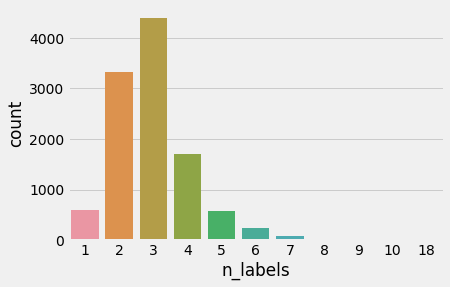

In [48]:
sns.countplot(df_clean[df_clean["bug"] == 1]["n_labels"])

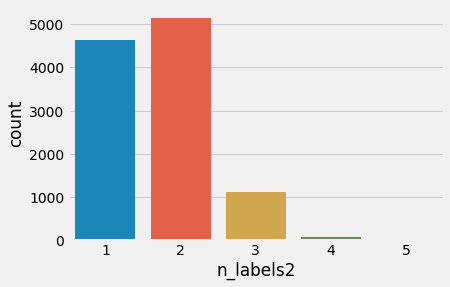

In [49]:
sns.countplot(df_clean[df_clean["bug"] == 1]["n_labels2"])

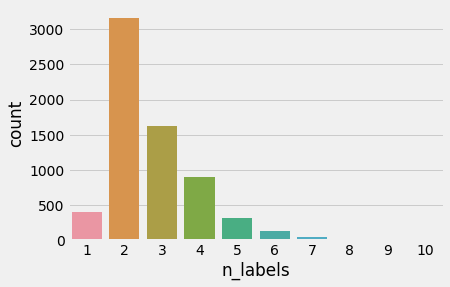

In [50]:
sns.countplot(df_clean[df_clean["feature-request"] == 1]["n_labels"])

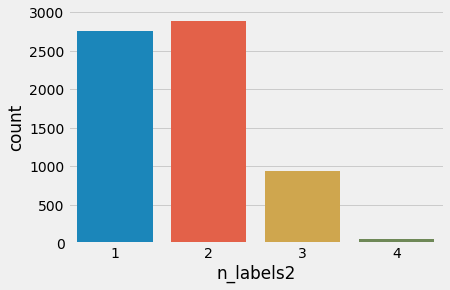

In [51]:
sns.countplot(df_clean[df_clean["feature-request"] == 1]["n_labels2"])

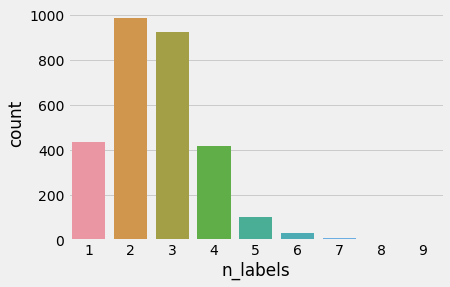

In [52]:
sns.countplot(df_clean[df_clean["debug"] == 1]["n_labels"])

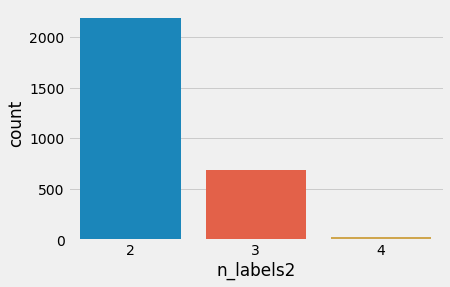

In [53]:
sns.countplot(df_clean[df_clean["debug"] == 1]["n_labels2"])

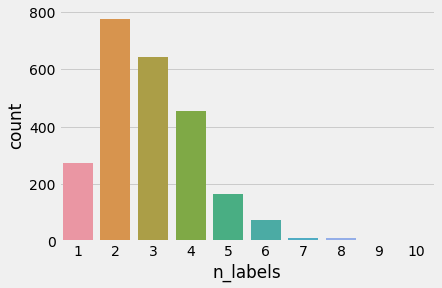

In [54]:
sns.countplot(df_clean[df_clean["workbench"] == 1]["n_labels"])

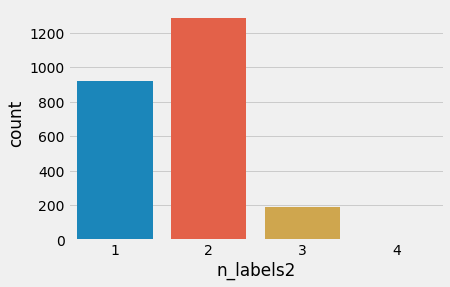

In [55]:
sns.countplot(df_clean[df_clean["workbench"] == 1]["n_labels2"])

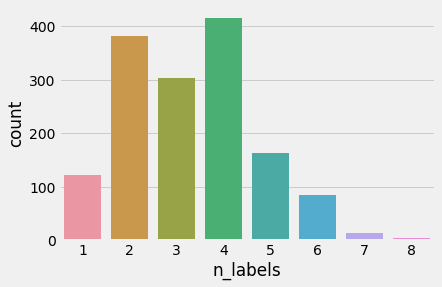

In [56]:
sns.countplot(df_clean[df_clean["javascript"] == 1]["n_labels"])

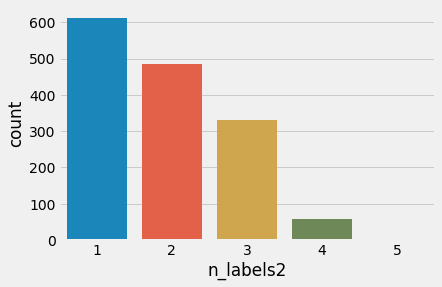

In [57]:
sns.countplot(df_clean[df_clean["javascript"] == 1]["n_labels2"])

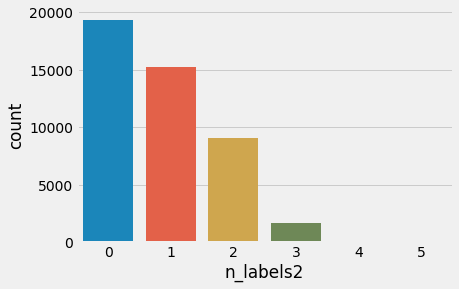

In [58]:
sns.countplot(df_clean["n_labels2"])

In [59]:
df.head()

number                                                url  \
0   52719  https://api.github.com/repos/Microsoft/vscode/...   
1   52718  https://api.github.com/repos/Microsoft/vscode/...   
2   52717  https://api.github.com/repos/Microsoft/vscode/...   
3   52716  https://api.github.com/repos/Microsoft/vscode/...   
4   52715  https://api.github.com/repos/Microsoft/vscode/...   

                                               title  \
0                       The extensions stops working   
1  Display function param type details instead of...   
2     Setting to change the image preview background   
3  When I use extension management, the applicati...   
4  Attach to process: cannot put process '18117' ...   

                                                body state   creator  \
0  <!-- Please search existing issues to avoid cr...  open  18577289   
1  <!-- Please search existing issues to avoid cr...  open    499364   
2  Hello,\r\n\r\nRight now whenever you open an i...  open   8916053   
3  Issue Type: <b>Bug</b>\r\nHi, vscode Team.\r\n...  open   5129173   
4  - VSCode Version: 1.24.1\r\n- OS Version: Mac ...  open   5215504   

             created_at  comments  subscribed  mentioned            labeled  \
0  2018-06-23T04:56:33Z         1           0          0       [extensions]   
1  2018-06-23T03:37:23Z         0           0          0       [javascript]   
2  2018-06-23T03:05:01Z         1           1          1                 []   
3  2018-06-23T02:08:53Z         0           0          0                 []   
4  2018-06-23T01:30:53Z         1           0          0  [debug, question]   

  unlabeled                                             status  \
0        []                                                 []   
1        []                                                 []   
2        []                                                 []   
3        []  [[closed, 2018-06-23T02:09:41Z], [reopened, 20...   
4        []                   [[closed, 2018-06-23T16:20:37Z]]   

                             assigned unassigned crossreference  duplicate  \
0                                  []         []             []          0   
1  [[12821956, 2018-06-23T03:37:44Z]]         []             []          0   
2                                  []         []             []          0   
3                                  []         []             []          0   
4   [[1898161, 2018-06-23T01:31:12Z]]         []             []          0   

            labels  
0       extensions  
1       javascript  
2                   
3                   
4  debug, question

In [60]:
df_clean.head()

number            labeled unlabeled           labels  debug  bug  \
0   52719       [extensions]        []       extensions      0    0   
1   52718       [javascript]        []       javascript      0    0   
2   52717                 []        []                       0    0   
3   52716                 []        []                       0    0   
4   52715  [debug, question]        []  debug, question      1    1   

   feature-request  workbench  editor  upstream    ...      extensions  \
0                0          0       0         0    ...               1   
1                0          0       0         0    ...               0   
2                0          0       0         0    ...               0   
3                0          0       0         0    ...               0   
4                0          0       0         0    ...               0   

   typescript  git  api  insiders  cla-not-required  integrated-terminal  \
0           0    0    0         0                 0                    0   
1           0    0    0         0                 0                    0   
2           0    0    0         0                 0                    0   
3           0    0    0         0                 0                    0   
4           0    0    0         0                 0                    0   

   search  n_labels  n_labels2  
0       0         1          1  
1       0         1          1  
2       0         0          0  
3       0         0          0  
4       0         2          2  

[5 rows x 21 columns]

In [61]:
df_ml = df_clean.drop(["labeled", "unlabeled","n_labels", "n_labels2"], axis=1)\
                                                    .merge(df[["number", "body", "title"]], on="number")

In [62]:
df_ml.head()

number           labels  debug  bug  feature-request  workbench  editor  \
0   52719       extensions      0    0                0          0       0   
1   52718       javascript      0    0                0          0       0   
2   52717                       0    0                0          0       0   
3   52716                       0    0                0          0       0   
4   52715  debug, question      1    1                0          0       0   

   upstream  javascript  extensions  typescript  git  api  insiders  \
0         0           0           1           0    0    0         0   
1         0           1           0           0    0    0         0   
2         0           0           0           0    0    0         0   
3         0           0           0           0    0    0         0   
4         0           0           0           0    0    0         0   

   cla-not-required  integrated-terminal  search  \
0                 0                    0       0   
1                 0                    0       0   
2                 0                    0       0   
3                 0                    0       0   
4                 0                    0       0   

                                                body  \
0  <!-- Please search existing issues to avoid cr...   
1  <!-- Please search existing issues to avoid cr...   
2  Hello,\r\n\r\nRight now whenever you open an i...   
3  Issue Type: <b>Bug</b>\r\nHi, vscode Team.\r\n...   
4  - VSCode Version: 1.24.1\r\n- OS Version: Mac ...   

                                               title  
0                       The extensions stops working  
1  Display function param type details instead of...  
2     Setting to change the image preview background  
3  When I use extension management, the applicati...  
4  Attach to process: cannot put process '18117' ...

# CLUSTERING

In [63]:
from sklearn.cluster import KMeans, DBSCAN

In [64]:
x_cluster = df_ml.apply(lambda row: row["title"] + row["body"], axis=1)
y_cluster = df_ml["labels"]

In [56]:
def tokenizing(text, stemming=False):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_words = []
    # filter out any tokens not containing letters (e.g., raw punctuation, numbers)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_words.append(token)
    # if we want to stemm the words:       
    if stemming:
        stemmed_words = [stemmer.stem(word) for word in filtered_words]
        return stemmed_words
    else:        
        return filtered_words

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x_cluster, y_cluster)

In [56]:
tf = TfidfVectorizer(max_features=50000, stop_words='english', max_df=0.8, ngram_range=(1,2),tokenizer=tokenizing)
tf_vectorizer = tf.fit(x_train)
xt_train = tf_vectorizer.transform(x_train)
xt_test = tf_vectorizer.transform(x_test)

In [58]:
km = KMeans(n_clusters=10).fit(xt_train)

In [59]:
pred = km.predict(xt_test)

In [60]:
visual_pred = pd.DataFrame(y_test)

In [61]:
visual_pred["cluster"] = pred

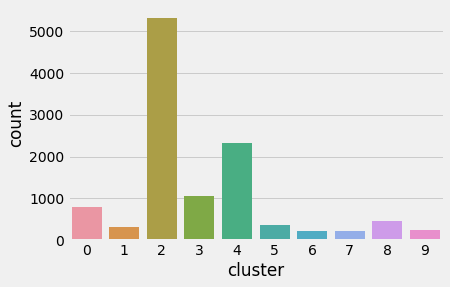

In [62]:
sns.countplot(visual_pred["cluster"])

In [63]:
visual_pred["cluster"].value_counts()

2    5309
4    2332
3    1070
0     791
8     472
5     357
1     312
9     251
7     225
6     220
Name: cluster, dtype: int64

In [64]:
# look at one cluster
cluster_labels = visual_pred[visual_pred["cluster"] == 3]

In [65]:
labels = [label.strip() for sublist in cluster_labels["labels"].values for label in sublist.split(",")]

In [66]:
pd.Series(labels).value_counts()[:20]

bug                    270
verified               245
feature-request        214
                       144
needs more info        117
workbench               91
question                49
git                     40
file-explorer           38
multi-root              38
search                  36
upstream                36
important               34
explorer-files          34
verification-needed     29
debug                   29
typescript              26
testplan-item           25
as-designed             24
api                     22
dtype: int64

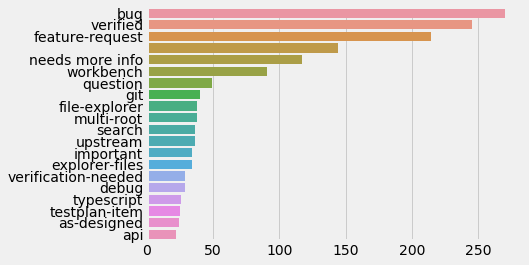

In [67]:
sns.barplot(x=pd.Series(labels).value_counts()[:20].values, y=pd.Series(labels).value_counts()[:20].index)

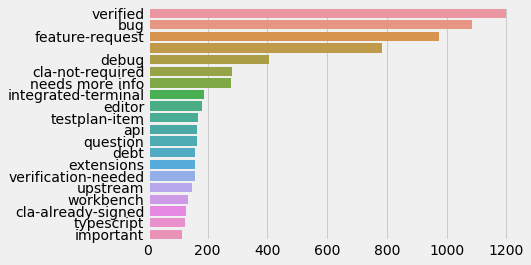

In [68]:
cluster_labels = visual_pred[visual_pred["cluster"] == 2]
labels = [label.strip() for sublist in cluster_labels["labels"].values for label in sublist.split(",")]
sns.barplot(x=pd.Series(labels).value_counts()[:20].values, y=pd.Series(labels).value_counts()[:20].index)

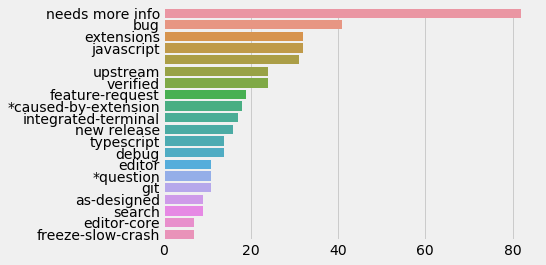

In [69]:
cluster_labels = visual_pred[visual_pred["cluster"] == 1]
labels = [label.strip() for sublist in cluster_labels["labels"].values for label in sublist.split(",")]
sns.barplot(x=pd.Series(labels).value_counts()[:20].values, y=pd.Series(labels).value_counts()[:20].index)

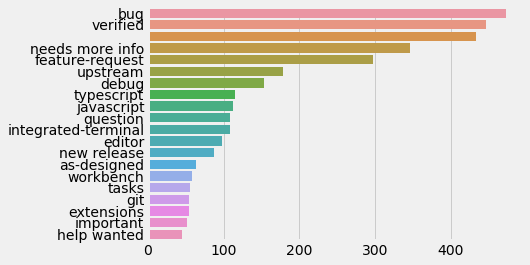

In [70]:
cluster_labels = visual_pred[visual_pred["cluster"] == 4]
labels = [label.strip() for sublist in cluster_labels["labels"].values for label in sublist.split(",")]
sns.barplot(x=pd.Series(labels).value_counts()[:20].values, y=pd.Series(labels).value_counts()[:20].index)

In [ ]:
cluster_labels = visual_pred[visual_pred["cluster"] == 8]
labels = [label.strip() for sublist in cluster_labels["labels"].values for label in sublist.split(",")]
sns.barplot(x=pd.Series(labels).value_counts()[:20].values, y=pd.Series(labels).value_counts()[:20].index)

# DBSCAN with 10k words

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x_cluster, y_cluster)

NameError: name 'train_test_split' is not defined

In [57]:
tf = TfidfVectorizer(max_features=10000, stop_words='english', max_df=0.8, ngram_range=(1,1),tokenizer=tokenizing)
x_vector = tf.fit_transform(x_cluster)


In [58]:
predictions_dbsca = DBSCAN().fit_predict(x_vector)

MemoryError: 

# Gensim LDA

In [1]:
from gensim import corpora, models, similarities 

In [ ]:
from nltk.corpus import stopwords

In [137]:
def tokenizing(text, stemming=False):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_words = []
    # filter out any tokens not containing letters (e.g., raw punctuation, numbers)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_words.append(token)
    # if we want to stemm the words:       
    if stemming:
        stemmed_words = [stemmer.stem(word) for word in filtered_words]
        return stemmed_words
    else:        
        return filtered_words

In [138]:
text_tok = [tokenizing(text) for text in x_cluster.values]


In [139]:
# remove stopwords
texts = [[word for word in text if word not in stopwords.words("english")] for text in text_tok]

In [140]:
dictionary = corpora.Dictionary(texts)

In [141]:
# to remove very common and very rare words
dictionary.filter_extremes(no_below=50, no_above=0.7)

In [142]:
len(dictionary)

3926

In [143]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [144]:
lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary, update_every=5, chunksize=10000, passes=10)

In [152]:
lda.show_topics()

[(0,
  '0.046*"Studio" + 0.028*"Code" + 0.026*"PM" + 0.023*"file" + 0.018*"src=" + 0.018*"shot" + 0.017*"https" + 0.017*"img" + 0.017*"npm" + 0.017*"screen"'),
 (1,
  '0.029*"git" + 0.023*"C" + 0.023*"name" + 0.021*"file" + 0.021*"VS" + 0.016*"c" + 0.015*"kind" + 0.014*"Files" + 0.013*"declare" + 0.013*"x86"'),
 (2,
  '0.042*"br" + 0.035*"Code" + 0.034*"enabled" + 0.024*"version" + 0.024*"VS" + 0.019*"System" + 0.018*"details" + 0.017*"summary" + 0.017*"/summary" + 0.017*"/details"'),
 (3,
  '0.042*"Version" + 0.037*"file" + 0.026*"VSCode" + 0.024*"I" + 0.023*"OS" + 0.017*"Reproduce" + 0.017*"Steps" + 0.014*"open" + 0.013*"https" + 0.011*"files"'),
 (4,
  '0.070*"br" + 0.055*"https" + 0.028*"function" + 0.022*"property" + 0.018*"code" + 0.015*"read" + 0.014*"Can" + 0.014*"file" + 0.013*"type" + 0.011*"anonymous"'),
 (5,
  '0.032*"Version" + 0.020*"VSCode" + 0.018*"terminal" + 0.017*"OS" + 0.013*"Steps" + 0.013*"Reproduce" + 0.011*"Please" + 0.011*"http" + 0.010*"error" + 0.010*"https"'

# LDA with TF-IDF

In [164]:
from gensim.matutils import Dense2Corpus

In [162]:
tf = TfidfVectorizer(max_features=25000, stop_words='english', max_df=0.75, ngram_range=(1,2),tokenizer=tokenizing)
x_vector = tf.fit_transform(x_cluster)

In [165]:
corp = Dense2Corpus(x_vector)

In [171]:
lda = models.LdaModel(corpus, num_topics=25, id2word=dictionary, update_every=5, chunksize=10000, passes=10)

In [172]:
lda.print_topics()

[(13,
  '0.028*"https" + 0.027*"Version" + 0.013*"OS" + 0.013*"VSCode" + 0.011*"issue" + 0.011*"code" + 0.010*"NVDA" + 0.010*"Steps" + 0.010*"error" + 0.010*"disabled"'),
 (4,
  '0.061*"Version" + 0.034*"VSCode" + 0.034*"OS" + 0.030*"https" + 0.025*"Steps" + 0.025*"Reproduce" + 0.020*"image" + 0.011*"folder" + 0.011*"path" + 0.010*"project"'),
 (22,
  '0.033*"I" + 0.017*"debug" + 0.015*"task" + 0.013*"run" + 0.012*"launch" + 0.011*"Version" + 0.010*"node" + 0.009*"VSCode" + 0.009*"build" + 0.009*"true"'),
 (6,
  '0.094*"x" + 0.022*"https" + 0.018*"Test" + 0.008*"test" + 0.007*"release" + 0.007*"Code" + 0.006*"extension" + 0.006*"version" + 0.006*"new" + 0.006*"Windows"'),
 (23,
  '0.044*"Version" + 0.025*"VSCode" + 0.024*"extensions" + 0.023*"Use" + 0.022*"OS" + 0.022*"check" + 0.021*"Help" + 0.021*"Report" + 0.021*"prefill" + 0.021*"`code"'),
 (24,
  '0.048*"br" + 0.036*"enabled" + 0.033*"Code" + 0.028*"version" + 0.023*"VS" + 0.021*"System" + 0.020*"details" + 0.020*"summary" + 0.020

In [173]:
from gensim.test.utils import common_texts

In [174]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

## WORDCLOUDS

In [200]:
from wordcloud import WordCloud, STOPWORDS

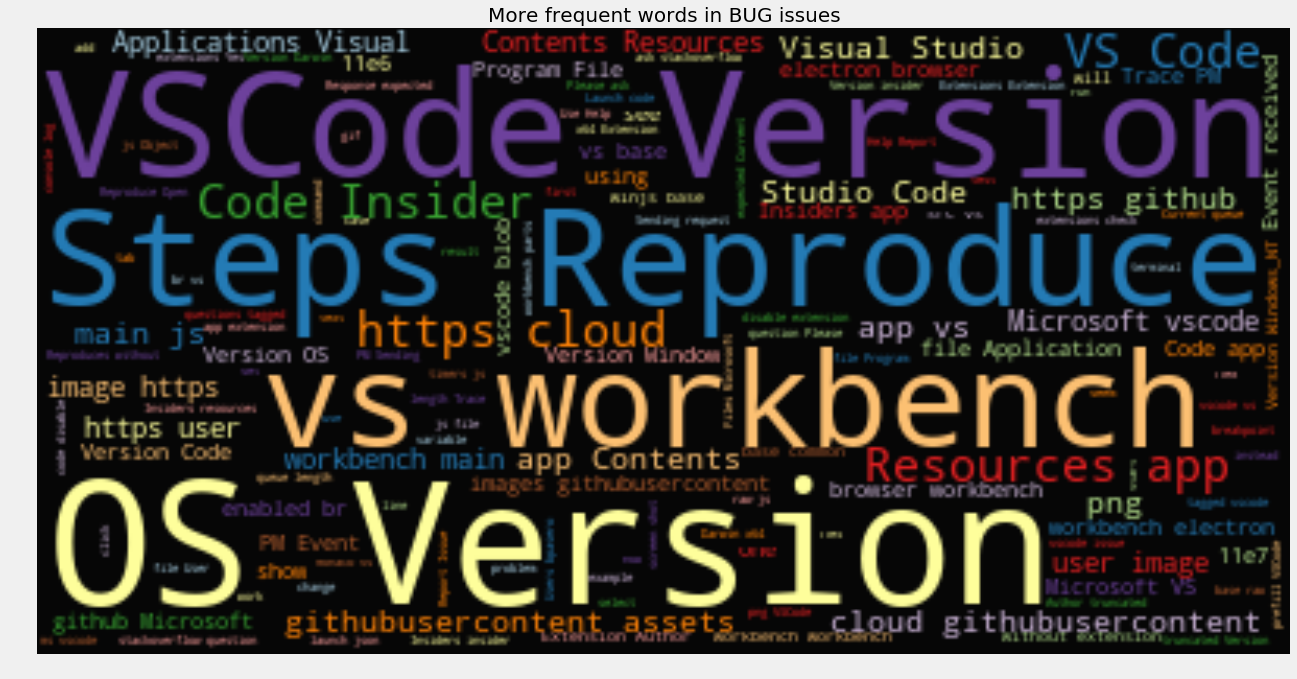

In [216]:
issue_wc = df_ml["body"][df_ml.bug == 1]

plt.figure(figsize=(20,12))
wc = WordCloud(background_color="black", max_words=200, stopwords=STOPWORDS)

wc.generate(" ".join(issue_wc))

plt.imshow(wc.recolor( colormap= 'Paired_r'), alpha=0.98, interpolation='bilinear')
plt.axis("off")
plt.title("More frequent words in BUG issues", fontsize=20);

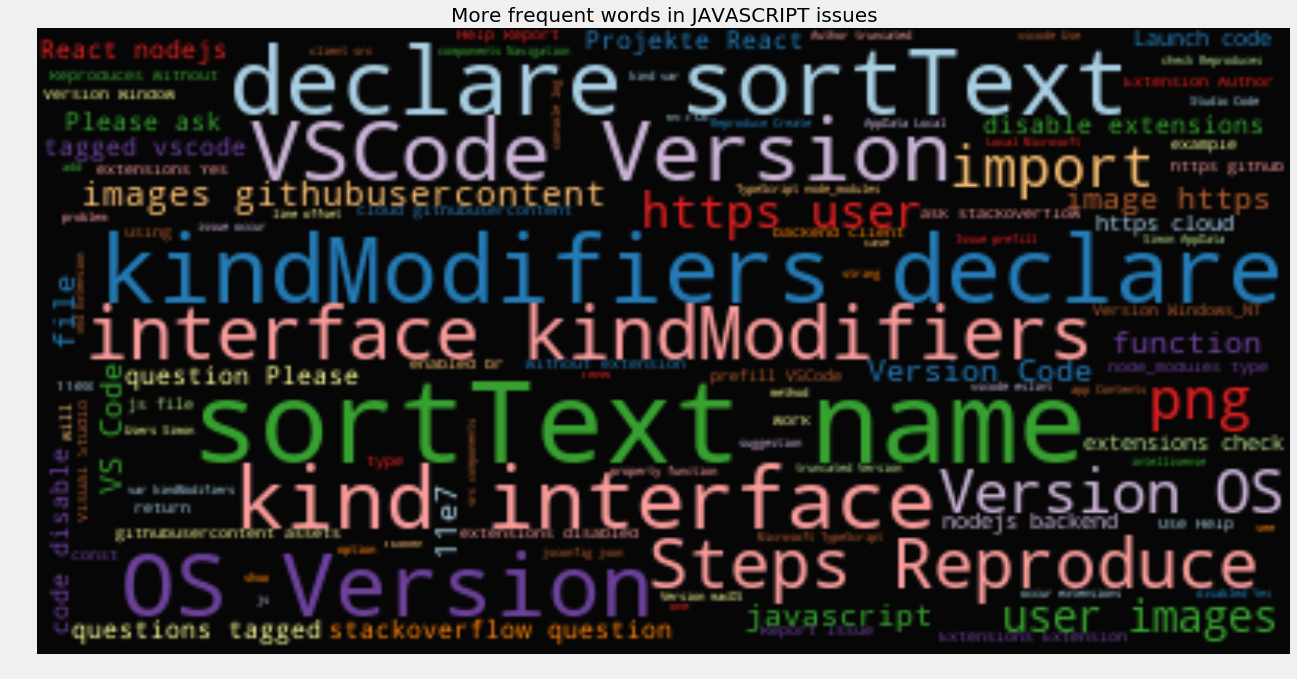

In [217]:
issue_wc = df_ml["body"][df_ml.javascript == 1]

plt.figure(figsize=(20,12))
wc = WordCloud(background_color="black", max_words=200, stopwords=STOPWORDS)

wc.generate(" ".join(issue_wc))

plt.imshow(wc.recolor( colormap= 'Paired_r'), alpha=0.98, interpolation='bilinear')
plt.axis("off")
plt.title("More frequent words in JAVASCRIPT issues", fontsize=20);

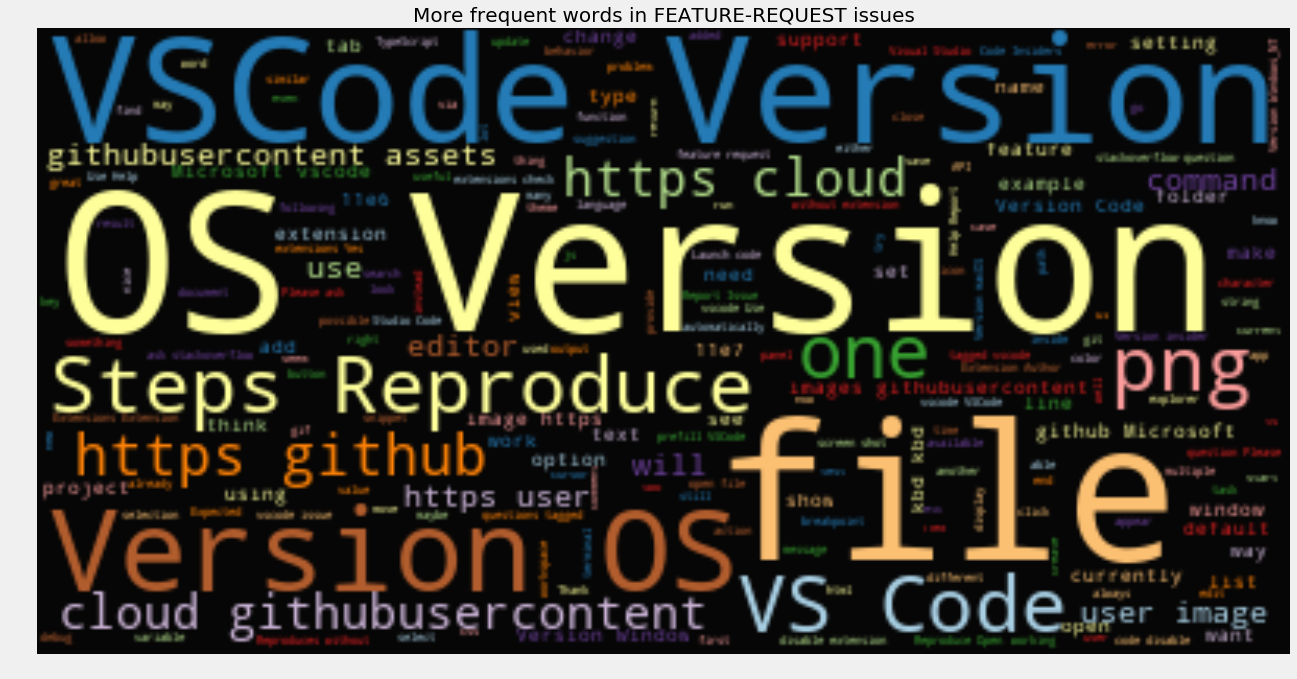

In [213]:
issue_wc = df_ml["body"][df_ml["feature-request"] == 1]

plt.figure(figsize=(20,12))
wc = WordCloud(background_color="black", max_words=200, stopwords=STOPWORDS)

wc.generate(" ".join(issue_wc))

plt.imshow(wc.recolor(colormap= 'Paired_r'), alpha=0.98, interpolation='bilinear')
plt.axis("off")
plt.title("More frequent words in FEATURE-REQUEST issues", fontsize=20);

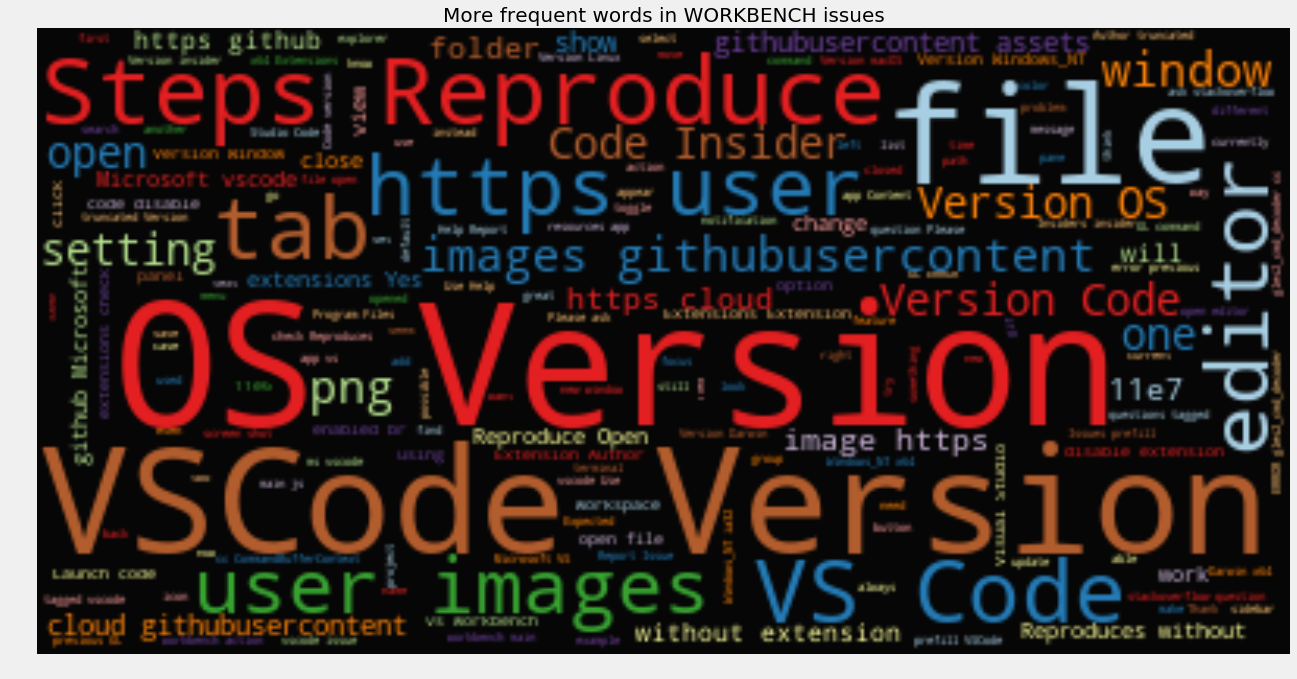

In [220]:
issue_wc = df_ml["body"][df_ml["workbench"] == 1]

plt.figure(figsize=(20,12))
wc = WordCloud(background_color="black", max_words=250, stopwords=STOPWORDS)

wc.generate(" ".join(issue_wc))

plt.imshow(wc.recolor(colormap= 'Paired_r'), alpha=0.98, interpolation='bilinear')
plt.axis("off")
plt.title("More frequent words in WORKBENCH issues", fontsize=20);

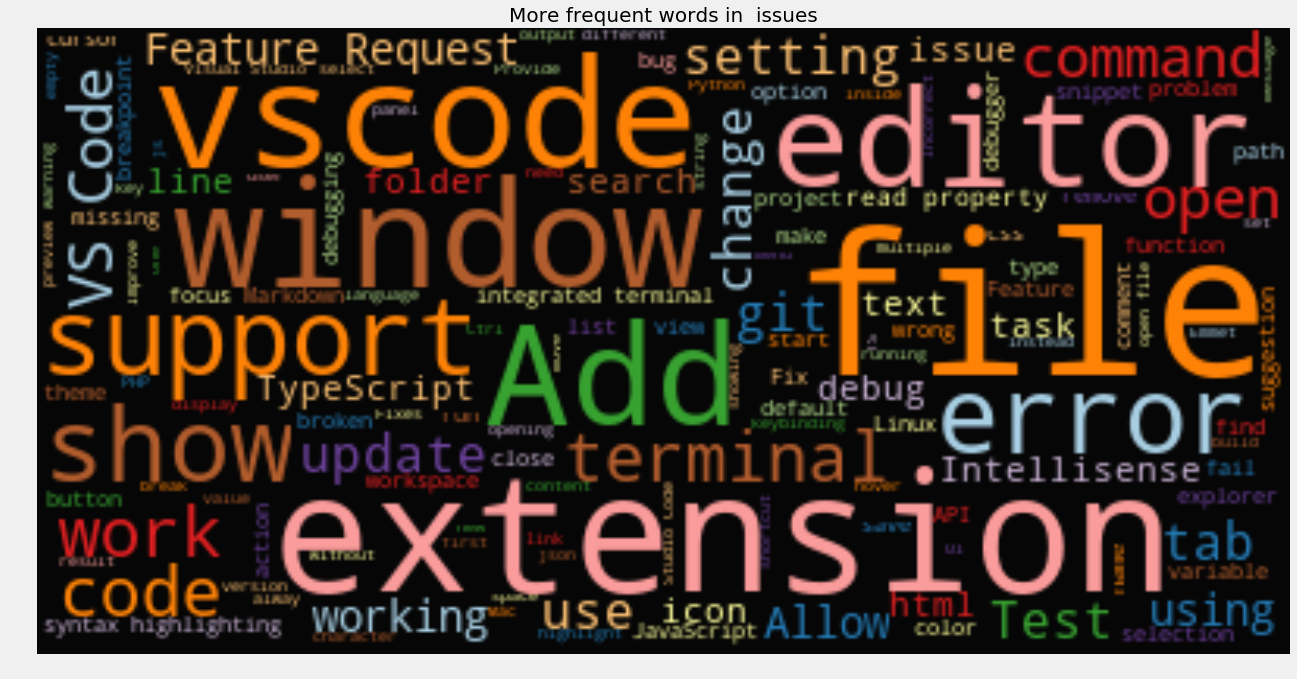

In [222]:
issue_wc = df_ml["title"]

plt.figure(figsize=(20,12))
wc = WordCloud(background_color="black", max_words=250, stopwords=STOPWORDS)

wc.generate(" ".join(issue_wc))

plt.imshow(wc.recolor(colormap= 'Paired_r'), alpha=0.98, interpolation='bilinear')
plt.axis("off")
plt.title("More frequent words in titles of issues", fontsize=20);

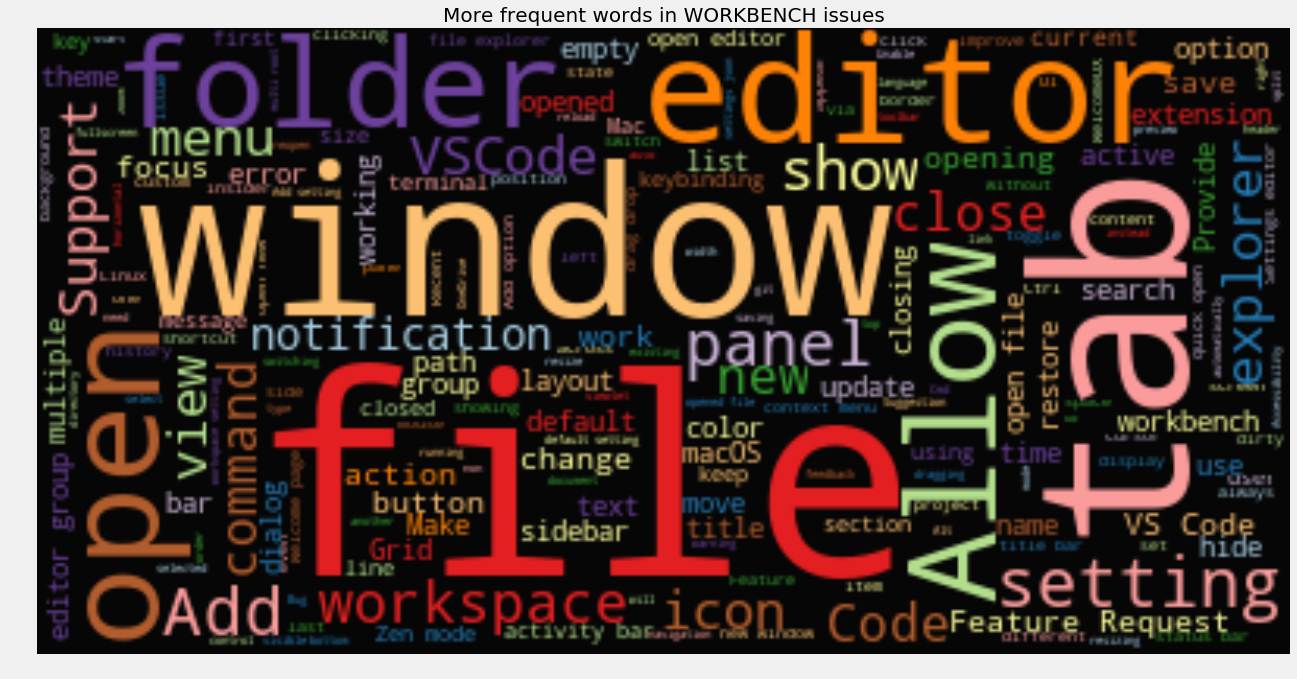

In [223]:
issue_wc = df_ml["title"][df_ml["workbench"] == 1]

plt.figure(figsize=(20,12))
wc = WordCloud(background_color="black", max_words=250, stopwords=STOPWORDS)

wc.generate(" ".join(issue_wc))

plt.imshow(wc.recolor(colormap= 'Paired_r'), alpha=0.98, interpolation='bilinear')
plt.axis("off")
plt.title("More frequent words in titles of WORKBENCH issues", fontsize=20);

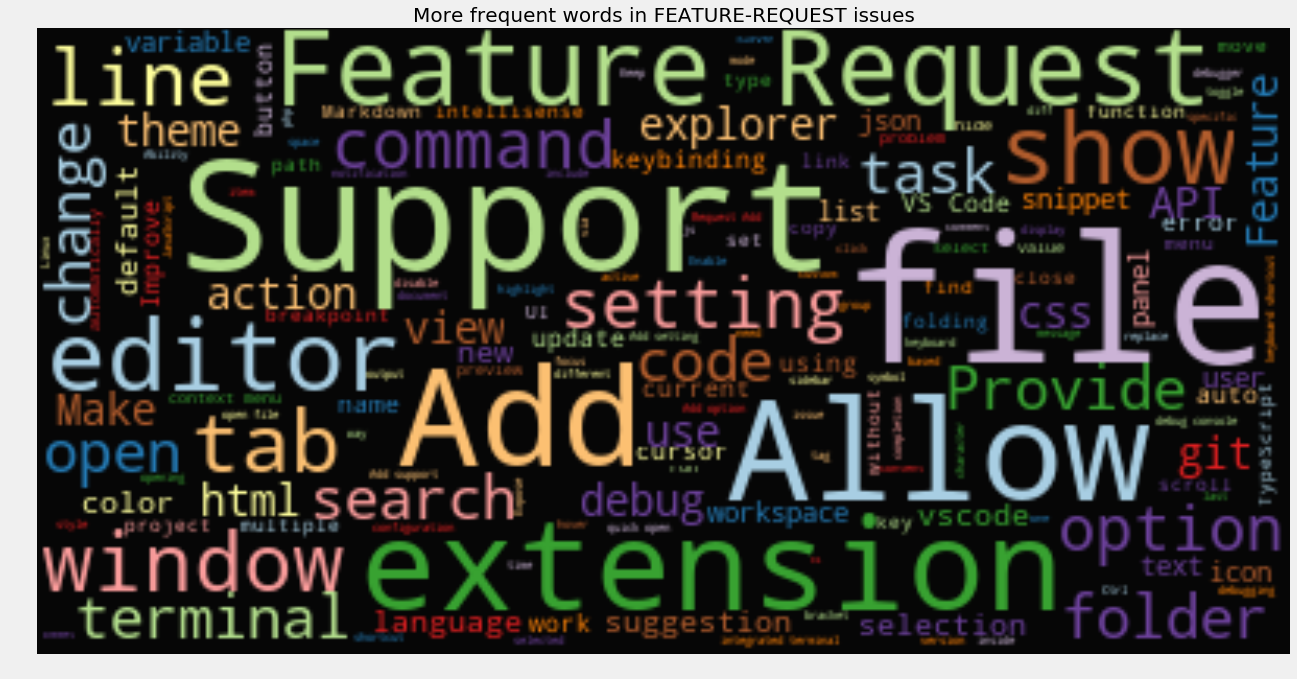

In [224]:
issue_wc = df_ml["title"][df_ml["feature-request"] == 1]

plt.figure(figsize=(20,12))
wc = WordCloud(background_color="black", max_words=200, stopwords=STOPWORDS)

wc.generate(" ".join(issue_wc))

plt.imshow(wc.recolor(colormap= 'Paired_r'), alpha=0.98, interpolation='bilinear')
plt.axis("off")
plt.title("More frequent words in titles of FEATURE-REQUEST issues", fontsize=20);

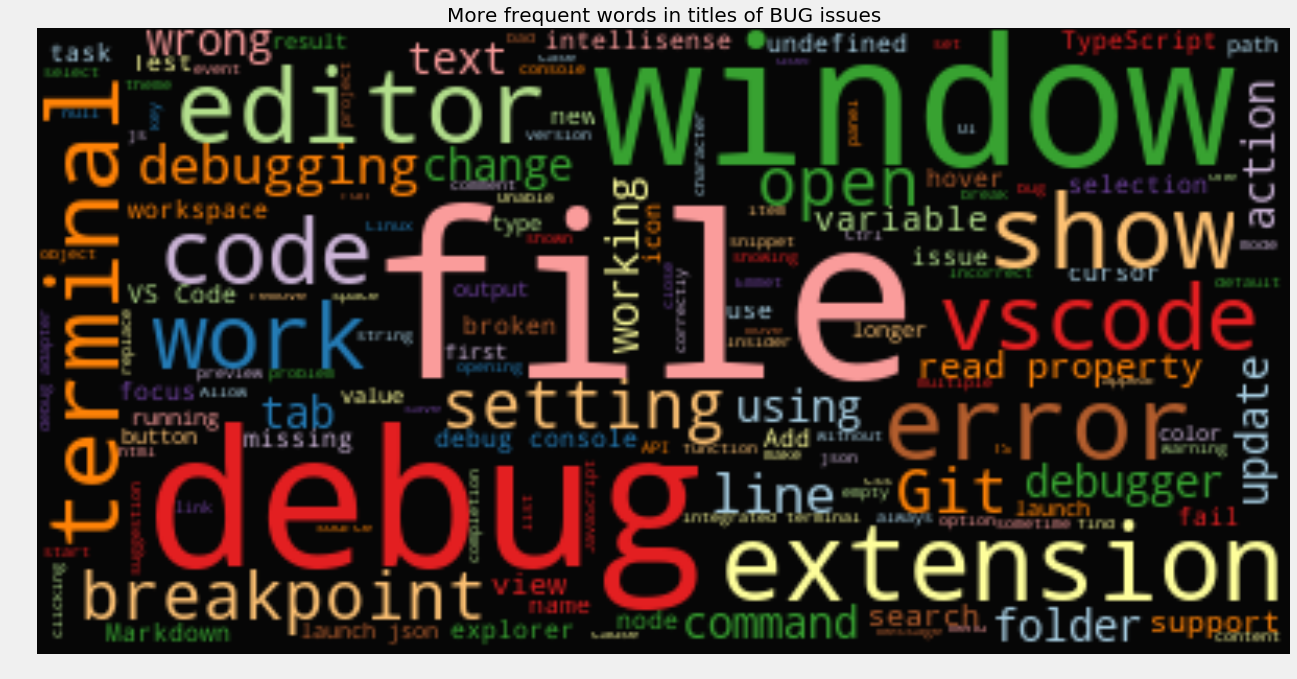

In [226]:
issue_wc = df_ml["title"][df_ml.bug == 1]

plt.figure(figsize=(20,12))
wc = WordCloud(background_color="black", max_words=200, stopwords=STOPWORDS)

wc.generate(" ".join(issue_wc))

plt.imshow(wc.recolor( colormap= 'Paired_r'), alpha=0.98, interpolation='bilinear')
plt.axis("off")
plt.title("More frequent words in titles of BUG issues", fontsize=20);

In [54]:
y_data.columns

Index(['debug', 'bug', 'feature-request', 'workbench', 'editor', 'upstream',
       'javascript', 'extensions', 'typescript', 'git', 'api', 'insiders',
       'cla-not-required', 'integrated-terminal', 'search'],
      dtype='object')

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data)

## TF-IDF

In [168]:
def tokenizing(text, stemming=False):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_words = []
    # filter out any tokens not containing letters (e.g., raw punctuation, numbers)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_words.append(token)
    # if we want to stemm the words:       
    if stemming:
        stemmed_words = [stemmer.stem(word) for word in filtered_words]
        return stemmed_words
    else:        
        return filtered_words

In [169]:
tf = TfidfVectorizer(max_features=50000, stop_words='english', max_df=0.8, ngram_range=(1,2),tokenizer=tokenizing)
tf_vectorizer = tf.fit(x_train)

In [170]:
xt_train = tf_vectorizer.transform(x_train)
xt_test = tf_vectorizer.transform(x_test)

In [60]:
# rf = RandomForestClassifier(n_estimators=100)

In [61]:
# rf.fit(xt_train, y_train)

In [62]:
# predictions = rf.predict(xt_test)

In [60]:
# print("Acuracy:", accuracy_score(y_test, predictions))
# print(classification_report(y_test, predictions, target_names=y_train.columns))

Acuracy: 0.4405150365993474
                     precision    recall  f1-score   support

              debug       0.85      0.11      0.19       713
                bug       0.76      0.17      0.28      2730
    feature-request       0.92      0.01      0.01      1658
          workbench       1.00      0.00      0.01       607
             editor       1.00      0.00      0.00       788
           upstream       0.33      0.00      0.00       490
         javascript       0.67      0.01      0.01       358
         extensions       0.71      0.05      0.09       323
         typescript       0.00      0.00      0.00       363
                git       1.00      0.01      0.01       276
                api       0.00      0.00      0.00       255
           insiders       0.57      0.03      0.05       154
   cla-not-required       0.62      0.06      0.11       293
integrated-terminal       1.00      0.02      0.04       391
             search       1.00      0.00      0.01      

/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
for label in y_test.columns:
    print(label, "apears", sum(y_train[label]), "times", round(sum(y_train[label])/y_train.shape[0]*100, 2), "%" )

debug apears 2188 times 6.43 %
bug apears 8219 times 24.16 %
feature-request apears 4964 times 14.59 %
workbench apears 1791 times 5.27 %
editor apears 2390 times 7.03 %
upstream apears 1513 times 4.45 %
javascript apears 1103 times 3.24 %
extensions apears 965 times 2.84 %
typescript apears 1058 times 3.11 %
git apears 821 times 2.41 %
api apears 700 times 2.06 %
insiders apears 483 times 1.42 %
cla-not-required apears 917 times 2.7 %
integrated-terminal apears 1216 times 3.57 %
search apears 609 times 1.79 %


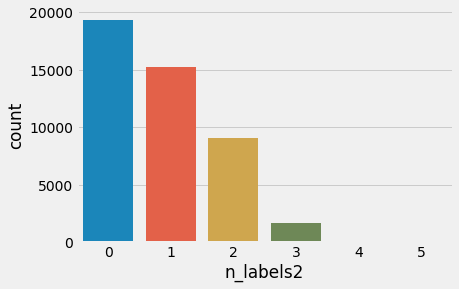

In [64]:
sns.countplot(df_clean["n_labels2"])

In [65]:
df_clean["n_labels2"].value_counts()

0    19341
1    15273
2     9019
3     1623
4       98
5        2
Name: n_labels2, dtype: int64

## almost half of the data doesn't have any label in here,

In [175]:
one = OneVsRestClassifier(LinearSVC(C=1)).fit(xt_train, y_train)

In [176]:
pred = one.predict(xt_test)

In [68]:
print("Acuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, target_names=y_train.columns))

Acuracy: 0.4701472793015257
                     precision    recall  f1-score   support

              debug       0.75      0.64      0.69       717
                bug       0.63      0.43      0.51      2744
    feature-request       0.58      0.33      0.42      1652
          workbench       0.50      0.13      0.20       612
             editor       0.63      0.30      0.40       821
           upstream       0.38      0.04      0.06       455
         javascript       0.66      0.25      0.36       385
         extensions       0.66      0.30      0.41       338
         typescript       0.56      0.26      0.35       325
                git       0.65      0.46      0.54       273
                api       0.54      0.16      0.24       236
           insiders       0.82      0.31      0.45       170
   cla-not-required       0.67      0.14      0.23       314
integrated-terminal       0.73      0.59      0.65       397
             search       0.65      0.43      0.52      

In [69]:
one = OneVsRestClassifier(RandomForestClassifier(n_estimators=10)).fit(xt_train, y_train)

In [70]:
pred = one.predict(xt_test)
print("Acuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, target_names=y_train.columns))

Acuracy: 0.4359290942763912
                     precision    recall  f1-score   support

              debug       0.72      0.32      0.44       717
                bug       0.67      0.16      0.26      2744
    feature-request       0.60      0.03      0.06      1652
          workbench       0.50      0.01      0.03       612
             editor       0.67      0.02      0.05       821
           upstream       0.25      0.00      0.00       455
         javascript       0.71      0.03      0.05       385
         extensions       0.67      0.09      0.15       338
         typescript       0.67      0.04      0.08       325
                git       0.57      0.07      0.13       273
                api       0.75      0.01      0.03       236
           insiders       0.74      0.12      0.20       170
   cla-not-required       0.65      0.07      0.13       314
integrated-terminal       0.76      0.28      0.41       397
             search       0.50      0.04      0.07      

In [71]:
from sklearn.linear_model import SGDClassifier

In [72]:
one = OneVsRestClassifier(SGDClassifier(max_iter=500)).fit(xt_train, y_train)

In [73]:
pred = one.predict(xt_test)
print("Acuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, target_names=y_train.columns))

Acuracy: 0.44677661169415295
                     precision    recall  f1-score   support

              debug       0.74      0.61      0.67       717
                bug       0.75      0.22      0.34      2744
    feature-request       0.33      0.00      0.00      1652
          workbench       0.50      0.00      0.01       612
             editor       0.82      0.01      0.02       821
           upstream       0.00      0.00      0.00       455
         javascript       1.00      0.00      0.01       385
         extensions       0.60      0.01      0.02       338
         typescript       0.00      0.00      0.00       325
                git       0.71      0.15      0.25       273
                api       0.00      0.00      0.00       236
           insiders       0.86      0.04      0.07       170
   cla-not-required       1.00      0.00      0.01       314
integrated-terminal       0.72      0.55      0.63       397
             search       0.65      0.11      0.18     

/home/alberto/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [171]:
features = tf_vectorizer.get_feature_names()

In [172]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row(document) and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=y_train.columns
    for col in cols:
        y_train_reset = y_train.reset_index()
        ids = y_train_reset[y_train_reset[col]==1].index
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [173]:
top_by_label = top_feats_by_class(xt_train, features)

In [140]:
y_train.columns

Index(['debug', 'bug', 'feature-request', 'workbench', 'editor', 'upstream',
       'javascript', 'extensions', 'typescript', 'git', 'api', 'insiders',
       'cla-not-required', 'integrated-terminal', 'search'],
      dtype='object')

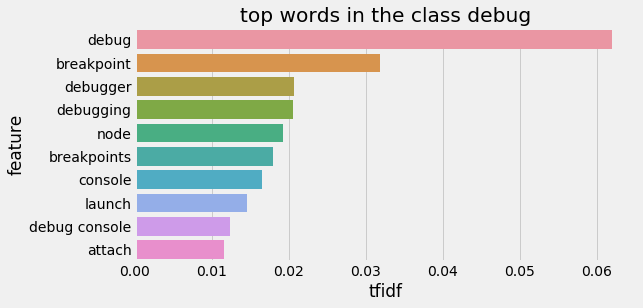

In [147]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[0][:10])
plt.title("top words in the class {}".format(y_train.columns[0]));

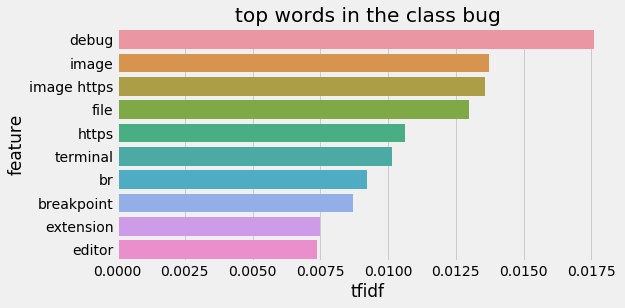

In [148]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[1][:10])
plt.title("top words in the class {}".format(y_train.columns[1]));

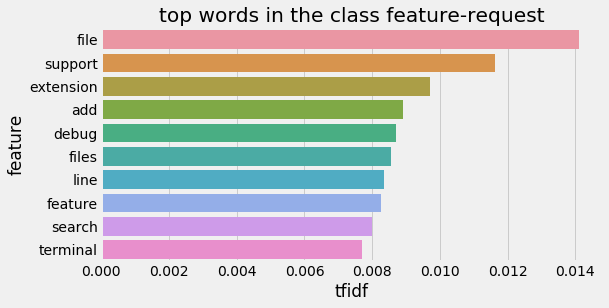

In [149]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[2][:10])
plt.title("top words in the class {}".format(y_train.columns[2]));

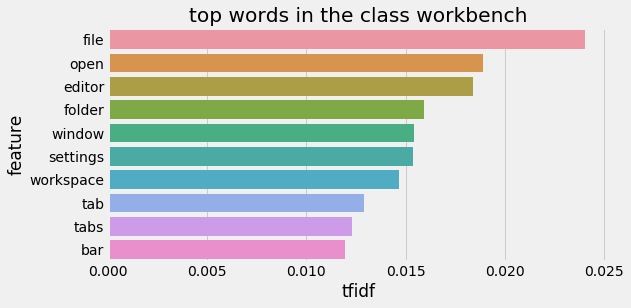

In [150]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[3][:10])
plt.title("top words in the class {}".format(y_train.columns[3]));

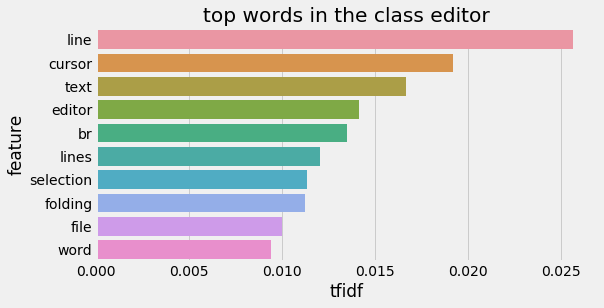

In [151]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[4][:10])
plt.title("top words in the class {}".format(y_train.columns[4]));

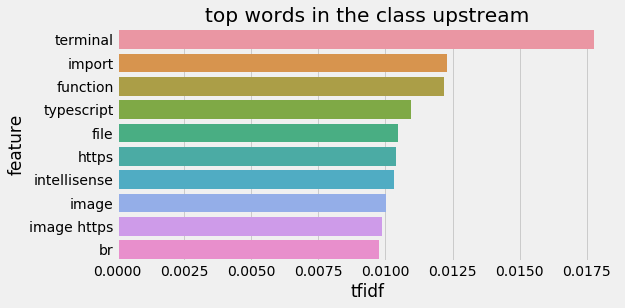

In [152]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[5][:10])
plt.title("top words in the class {}".format(y_train.columns[5]));

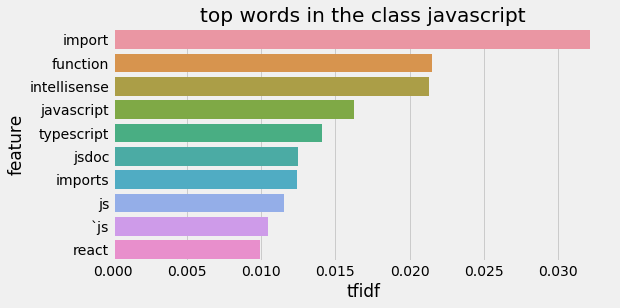

In [153]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[6][:10])
plt.title("top words in the class {}".format(y_train.columns[6]));

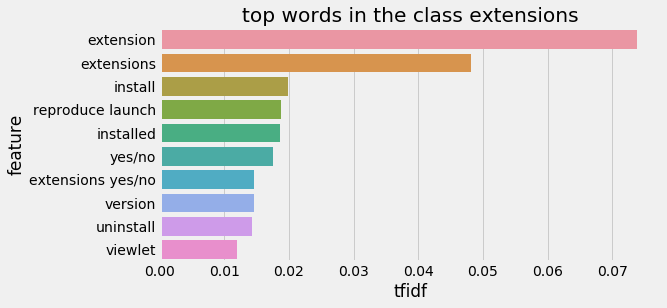

In [154]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[7][:10])
plt.title("top words in the class {}".format(y_train.columns[7]));

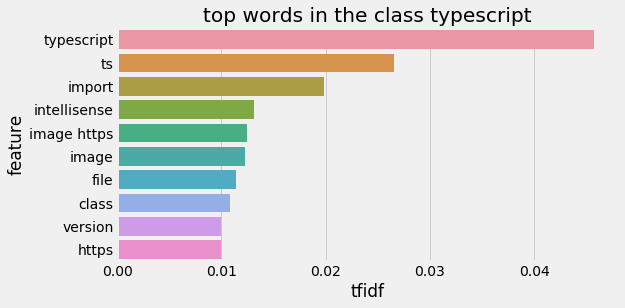

In [155]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[8][:10])
plt.title("top words in the class {}".format(y_train.columns[8]));

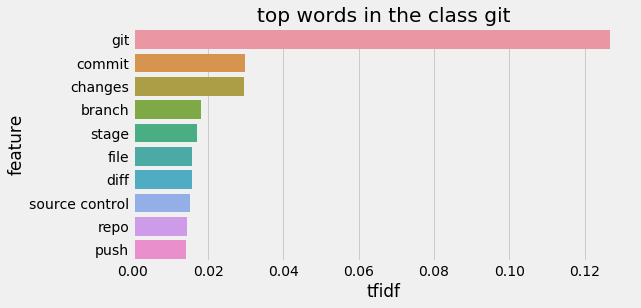

In [156]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[9][:10])
plt.title("top words in the class {}".format(y_train.columns[9]));

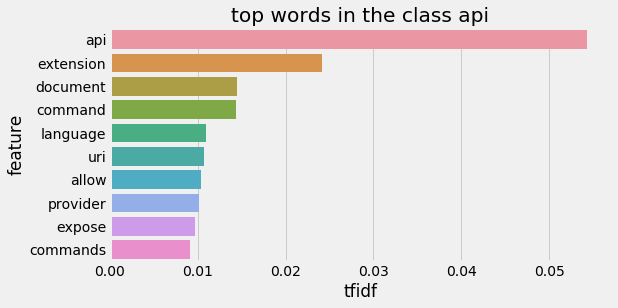

In [157]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[10][:10])
plt.title("top words in the class {}".format(y_train.columns[10]));

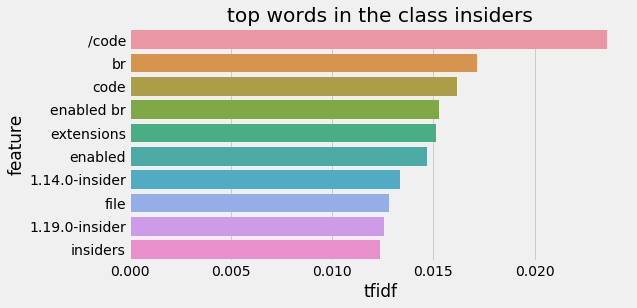

In [158]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[11][:10])
plt.title("top words in the class {}".format(y_train.columns[11]));

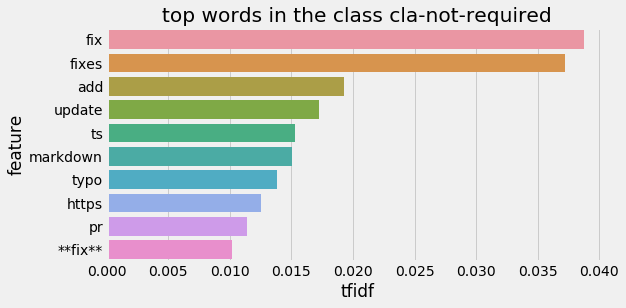

In [159]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[12][:10])
plt.title("top words in the class {}".format(y_train.columns[12]));

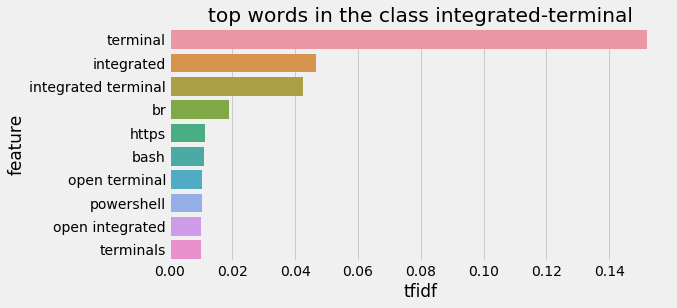

In [160]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[13][:10])
plt.title("top words in the class {}".format(y_train.columns[13]));

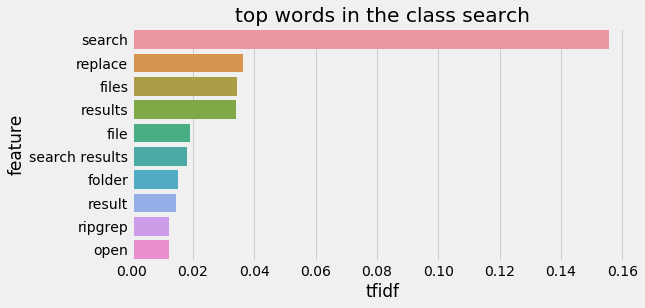

In [161]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[14][:10])
plt.title("top words in the class {}".format(y_train.columns[14]));

## with Lemmatizing

In [196]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemattizing(text, stemming=True):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_words = []
    # filter out any tokens not containing letters (e.g., raw punctuation, numbers)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_words.append(token)
    # if we want to stemm the words:       
    if stemming:
        stemmed_words = [lemmatizer.lemmatize(word) for word in filtered_words]
        return stemmed_words
    else:        
        return filtered_words

In [189]:
tf = TfidfVectorizer(max_features=100000, stop_words='english', max_df=0.8, ngram_range=(1,2),tokenizer=lemattizing)
tf_vectorizer = tf.fit(x_train)
xt_train = tf_vectorizer.transform(x_train)
xt_test = tf_vectorizer.transform(x_test)

In [190]:
features = tf_vectorizer.get_feature_names()

In [191]:
top_by_label = top_feats_by_class(xt_train, features)

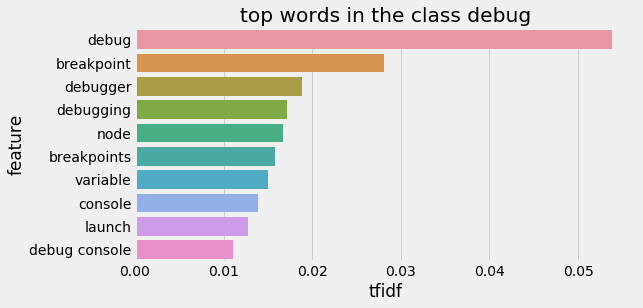

In [192]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[0][:10])
plt.title("top words in the class {}".format(y_train.columns[0]));

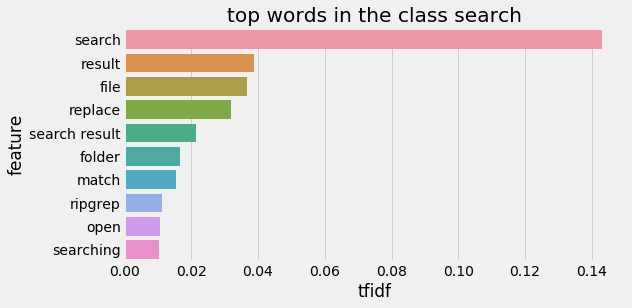

In [193]:
plt.figure(figsize=(8,4))
sns.barplot(y="feature", x= "tfidf", data= top_by_label[14][:10])
plt.title("top words in the class {}".format(y_train.columns[14]));

In [194]:
one = OneVsRestClassifier(LinearSVC(C=1)).fit(xt_train, y_train)

In [195]:
pred = one.predict(xt_test)
print("Acuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, target_names=y_train.columns))

Acuracy: 0.4657377193756063
                     precision    recall  f1-score   support

              debug       0.76      0.63      0.69       717
                bug       0.62      0.43      0.51      2744
    feature-request       0.56      0.31      0.40      1652
          workbench       0.47      0.13      0.20       612
             editor       0.61      0.30      0.40       821
           upstream       0.42      0.05      0.09       455
         javascript       0.70      0.26      0.38       385
         extensions       0.65      0.29      0.40       338
         typescript       0.54      0.26      0.35       325
                git       0.64      0.45      0.53       273
                api       0.53      0.15      0.24       236
           insiders       0.80      0.28      0.41       170
   cla-not-required       0.63      0.17      0.27       314
integrated-terminal       0.72      0.56      0.63       397
             search       0.66      0.42      0.51      